## ESPP 90S Final Project: Ammonia x Wind
### Alaisha Sharma and Rowen VonPlagenhoef

In [134]:
import numpy as np
import matplotlib.pyplot as plt

### PARAMETERS

#### Wind Facility

In [135]:
num_turbine = 30                  # --
life_turbine = 20                 # yr
nameplate_turbine = 2             # MW
capacity_factor_turbine = 0.35    # --

#### Ammonia Facility

In [136]:
life_backup = 10                 # yr 
capacity_factor_backup = 0.90    # --          
backup_energy_fraction = 0.1     # --
ammonia_energy_usage = 11.6      # MW-hr/ton 
ammonia_diesel_energy = 4.75     # MW-hr/ton
num_storage = 900                # --

#### Capital Costs

In [137]:
cc_land = 375e3       # $
cc_well = 30e3        # $
cc_wind = 1400        # $/kW
cc_backup = 650       # $/kW
cc_storage = 900      # $/ton
cc_ammonia = 1.3e6    # $/ton-day

#### O&M Costs

In [138]:
num_worker = 50         # --
worker_salary = 60e3    # $/yr
om_turbine = 44         # $/kW-yr
om_backup = 15          # $/kW-yrs
om_ammonia = 133        # $/ton

#### Transportation

In [150]:
tr_hrs = 4            # hr/day
tr_distance = 150     # km/day
tr_cost = 0.12        # $/km
tr_rate = 450         # kg/hr

#### Other

In [140]:
interest_rate = 0.045    # $/yr

### FUNCTIONS

#### Annual Output

In [162]:
def annual_wind_output(params):
    # --  *  MW  *  --  *  hr/yr  =  MW-hr/yr
    return params['num_turbine']*params['nameplate_turbine']*params['capacity_factor_turbine']*8760

def annual_ammonia_output(params):
    # MW-hr/yr  *   ton/MW-hr  =  ton/yr
    return annual_wind_output(params)/params['ammonia_energy_usage']

def annual_ammonia_available(params):
    # ton/yr
    output = annual_ammonia_output(params)
    # ton/yr  -  (ton/day  *  day/yr)  =  ton/yr
    return output-daily_ammonia_fuel_backup(params)*365

#### Backup Generation

In [154]:
def backup_generation_size(params):
    # --  *  hr/day  =  hr/day
    hours = (1-params['capacity_factor_turbine'])*24
    # MW-hr/yr  *  yr/day  *  --  =  MW-hr/day
    energy = annual_wind_output(params)/365*params['backup_energy_fraction']
    # MW-hr/day  *  day/hr  =  MW
    return energy/hours

def daily_ammonia_fuel_backup(params):
    # --  *  hr/day  =  hr/day
    hours = (1-params['capacity_factor_turbine'])*24
    # MW  *  hr/day  =  MW-hr/day
    capacity = backup_generation_size(params)*hours
    # MW-hr/day  *  ton/MW-hr  =  ton/day
    return capacity/params['ammonia_diesel_energy']

#### Capital Costs - Wind Only

In [155]:
def capital_cost_wind_only(params):
    # --  *  MW  *  $/kW  *  kW/MW  =  $
    return params['num_turbine']*params['nameplate_turbine']*params['cc_wind']*1e3

def pmt_wind_only(params):
    # $
    capital = capital_cost_wind_only(params)
    # $/yr
    return -1*np.pmt(params['interest_rate'], params['life_turbine'], capital)

def lcoe_wind_only(params):
    # $/yr  /  (MW-hr/yr  *  kW/MW)  =  $/kW-hr
    return pmt_wind_only(params)/(annual_wind_output(params)*1e3)

#### Capital Costs - Wind with Ammonia

In [144]:
def capital_cost_wind_ammonia(params):
    # --
    multiplier = params['life_turbine']/params['life_backup']
    # $
    wind = capital_cost_wind_only(params)
    # $/kW  *  kW/MW  *  MW  *  --  =  $
    backup = params['cc_backup']*1e3*backup_generation_size(params)*multiplier
    # $/ton-day  *  ton/yr  *  yr/day  =  $
    ammonia = params['cc_ammonia']*annual_ammonia_output(params)/365
    # $  *  --  =  $
    storage = params['cc_storage']*params['num_storage']
    # $
    return params['cc_land']+params['cc_well']+wind+backup+ammonia+storage
    
def pmt_wind_ammonia(params):
    # $
    capital = capital_cost_wind_ammonia(params)
    # $/yr
    return -1*np.pmt(params['interest_rate'], params['life_turbine'], capital)

def lcoe_wind_ammonia(params):
    # --  *  MW-hr/yr  *  kW/MW  =  kW-hr/yr
    energy = (1-params['backup_energy_fraction'])*(annual_wind_output(params)*1e3)
    # $/yr  *  yr/kW-hr    =  $/kW-hr
    return (pmt_wind_ammonia(params)+om_cost_wind_ammonia(params))/energy

#### O&M Costs

In [145]:
def om_cost_workers(params):
    # --  *  $/yr  = $/yr
    return params['num_worker']*params['worker_salary']

def om_cost_turbine(params):
    # MW-hr/yr
    power = annual_wind_output(params)
    # $/kW-yr  *  MW-hr/yr  *  kW/MW  *  yr/hr  =  $/yr
    return params['om_turbine']*power*1e3/8760

def om_cost_backup(params):
    # $/kW-yr  *  MW/kW  *  MW  =  $/yr
    return params['om_backup']*1e3*backup_generation_size(params)

def om_cost_ammonia(params):
    # ton/yr
    ammonia = annual_ammonia_output(params)
    # $/ton  *  ton/yr  =  $/yr
    return params['om_ammonia']*ammonia

def om_cost_wind_ammonia(params):
    # $
    return om_cost_workers(params)+om_cost_turbine(params)+om_cost_ammonia(params)+om_cost_backup(params)

#### Transportation Costs

In [156]:
def single_truck_capacity(params):
    # kg/hr  *  ton/kg  *  hr/day  =  ton/day
    return params['tr_rate']*0.0011*params['tr_hrs']

def number_trucks(params):
    # ton/day
    capacity = single_truck_capacity(params)
    # ton/yr
    ammonia = annual_ammonia_available(params)
    # ton/yr  *  yr/day  *  day/ton  =  --
    return ammonia/365/capacity

def transport_cost(params):
    # --
    num_truck = number_trucks(params)
    # $/km  *  km/day  *  day/yr  *  --  =  $/yr
    return params['tr_cost']*params['tr_distance']*365*num_truck

#### Final Ammonia Fuel Prices

In [157]:
def production_ammonia_price(params):
    # $/kW-hr
    lcoe = lcoe_wind_ammonia(params)
    # $/kW-hr  *  kW/MW  *  MW-hr/ton  =   $/ton
    return lcoe*1e3*params['ammonia_energy_usage']
    
def distribution_ammonia_price(params):
    # $/ton
    production = production_ammonia_price(params)
    # $/yr  *  yr/ton  =  $/ton
    transport = transport_cost(params)/annual_ammonia_available(params)
    # $/ton
    return production+transport

### CALCULATIONS

In [163]:
params_baseline = {
    'num_turbine': 30,
    'life_turbine': 20,
    'nameplate_turbine': 2,
    'capacity_factor_turbine': 0.35,
    'life_backup': 10,
    'capacity_factor_backup': 0.90,
    'backup_energy_fraction': 0.1,
    'ammonia_energy_usage': 11.6,
    'ammonia_diesel_energy': 4.75,
    'num_storage': 900,
    'cc_land': 375e3,
    'cc_well': 30e3,
    'cc_wind': 1400,
    'cc_backup': 650,
    'cc_ammonia': 1.3e6,
    'cc_storage': 900,
    'num_worker': 50,
    'worker_salary': 60e3,
    'om_turbine': 44,
    'om_backup': 15,
    'om_ammonia': 133,
    'tr_hrs': 4,
    'tr_distance': 150,
    'tr_cost': 0.12,
    'tr_rate': 450,
    'interest_rate': 0.045
}

In [168]:
print()
print("BASELINE CALCULATIONS FOR WIND + AMMONIA PLANT:")
print("-" * 47 + "\n")
print("Output of wind plant: {:.1f} MW-hr/day".format(annual_wind_output(params_baseline)/365))
print("                      {} MW-hr/yr \n".format(round(annual_wind_output(params_baseline))))
print("Output of ammonia plant: {:.1f} tons/day".format(annual_ammonia_output(params_baseline)/365))
print("                         {} tons/yr \n".format(round(annual_ammonia_output(params_baseline))))
print()
print("Size of backup generator required: {:.1f} MW \n".format(backup_generation_size(params_baseline)))
print("Ammonia fuel used for backup generation: {:.1f} ton/day \n".format(daily_ammonia_fuel_backup(params_baseline)))
print()
print("Total capital costs of only wind plant: {:.1f} million USD \n".format(capital_cost_wind_only(params_baseline)/1e6))
print("Total capital costs of wind and ammonia plant: {:.1f} million USD\n".format(capital_cost_wind_ammonia(params_baseline)/1e6))
print()
print("PMT costs of wind plant: {:.2f} million USD/yr \n".format(pmt_wind_only(params_baseline)/1e6))
print("PMT costs of wind and ammonia plant: {:.2f} million USD/yr \n".format(pmt_wind_ammonia(params_baseline)/1e6))
print()
print("O&M costs of wimd and ammonia plant: {:.2f} million USD/yr \n".format(om_cost_wind_ammonia(params_baseline)/1e6))
print()
print("LCOE of wind plant: {:.3f} USD/kWh \n".format(lcoe_wind_only(params_baseline)))
print("LCOE of wind and ammonia plant: {:.3f} USD/yr \n".format(lcoe_wind_ammonia(params_baseline)))
print()
print("Transport cost of ammonia: {} USD/yr \n".format(round(transport_cost(params_baseline))))
print()
print("Production cost of ammonia fuel: {:.2f} $/ton \n".format(production_ammonia_price(params_baseline)))
print("Distribution cost of ammonia fuel: {:.2f} $/ton \n".format(distribution_ammonia_price(params_baseline)))


BASELINE CALCULATIONS FOR WIND + AMMONIA PLANT:
-----------------------------------------------

Output of wind plant: 504.0 MW-hr/day
                      183960 MW-hr/yr 

Output of ammonia plant: 43.4 tons/day
                         15859 tons/yr 


Size of backup generator required: 3.2 MW 

Ammonia fuel used for backup generation: 10.6 ton/day 


Total capital costs of only wind plant: 84.0 million USD 

Total capital costs of wind and ammonia plant: 145.9 million USD


PMT costs of wind plant: 6.46 million USD/yr 

PMT costs of wind and ammonia plant: 11.22 million USD/yr 


O&M costs of wimd and ammonia plant: 6.08 million USD/yr 


LCOE of wind plant: 0.035 USD/kWh 

LCOE of wind and ammonia plant: 0.104 USD/yr 


Transport cost of ammonia: 108962 USD/yr 


Production cost of ammonia fuel: 1211.94 $/ton 

Distribution cost of ammonia fuel: 1221.03 $/ton 



### GRAPHS

#### Cost Multipliers

In [170]:
def apply_multipliers_single_param(params, param_name, multipliers):
    params_multiplied = []
    for m in multipliers:
        params_m = params.copy()
        params_m[param_name] *= m
        params_multiplied.append(params_m)
    return params_multiplied

def calculate_with_multipliers(params, param_name, multipliers, func_name):
    params_multiplied = apply_multipliers_single_param(params, param_name, multipliers)
    calculations = np.asarray([func_name(pm) for pm in params_multiplied])
    return calculations

def sensitivity_to_multipliers(params, param_names, multipliers, func_name):
    param_name_to_prices = dict()
    for p in param_names:
        calculations = calculate_with_multipliers(params, p, multipliers, func_name)
        param_name_to_prices[p] = calculations
    return param_name_to_prices

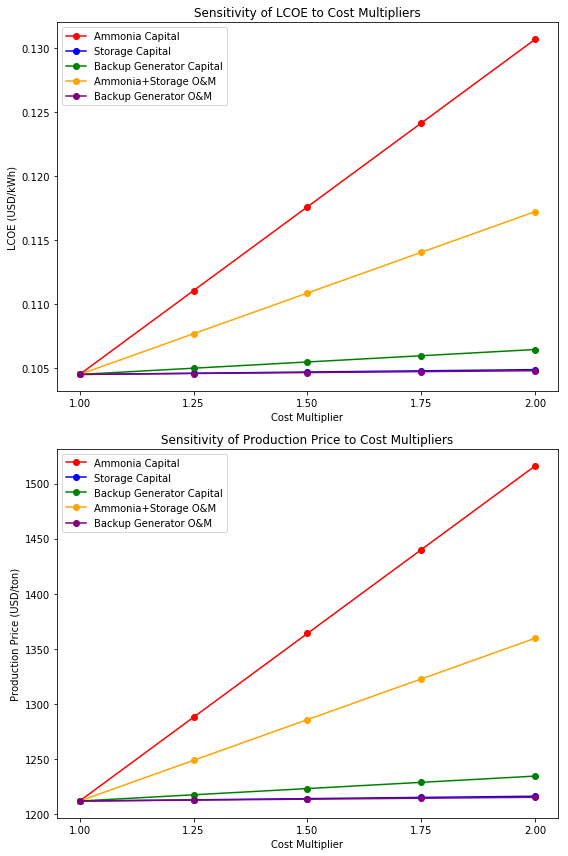

In [192]:
param_names = ['cc_ammonia', 'cc_storage', 'cc_backup', 'om_ammonia', 'om_backup']
multipliers = np.arange(1, 2.25, 0.25)

lcoe_multiplied = sensitivity_to_multipliers(params_baseline, param_names, multipliers, lcoe_wind_ammonia)
production_price_multiplied = sensitivity_to_multipliers(params_baseline, param_names, multipliers, production_ammonia_price)

titles = ["LCOE", "Production Price"]
labels = ["Ammonia Capital", "Storage Capital", "Backup Generator Capital", "Ammonia+Storage O&M", "Backup Generator O&M"]
colors = ['red', 'blue', 'green', 'orange', 'purple']
ylabels = ["LCOE (USD/kWh)", "Production Price (USD/ton)"]
data_to_plot = [lcoe_multiplied, production_price_multiplied]

fig, axs = plt.subplots(len(data_to_plot), figsize=(8, 12))
width = 0.25

for i in range(len(data_to_plot)):
    ax = axs[i]
    x = multipliers
    dp = data_to_plot[i]
    for j in range(len(param_names)):
        p = param_names[j]
        ax.plot(x, dp[p], marker='o', label=labels[j], color=colors[j])
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel("Cost Multiplier")
    ax.set_xticks(x)
    ax.set_title("Sensitivity of {} to Cost Multipliers".format(titles[i]))
    ax.legend()

fig.tight_layout()
plt.show()

#### Cost Breakdowns

In [207]:
def capital_cost_breakdown(params, multipliers):
    capital = np.zeros([6])
    backup_factor = params['life_turbine']/params['life_backup']
    capital[0] = params['cc_land']*multipliers[0]
    capital[1] = params['cc_well']*multipliers[1]
    capital[2] = capital_cost_wind_only(params)*multipliers[2]
    capital[3] = params['cc_backup']*1e3*backup_generation_size(params)*backup_factor*multipliers[3]
    capital[4] = params['cc_ammonia']*annual_ammonia_output(params)/365*multipliers[4]
    capital[5] = params['cc_storage']*params['num_storage']*multipliers[5]
    return (capital, capital/np.sum(capital))

def om_cost_breakdown(params, multipliers):
    om = np.zeros([5])
    om[0] = om_cost_workers(params)*multipliers[0]
    om[1] = om_cost_turbine(params)*multipliers[1]
    om[2] = om_cost_backup(params)*multipliers[2]
    om[3] = om_cost_ammonia(params)*multipliers[3]
    om[4] = transport_cost(params)*multipliers[4]
    return (om, om/np.sum(om))

def format_percents(percents):
    return ["{:.2f}%".format(p*1e2) for p in percents]

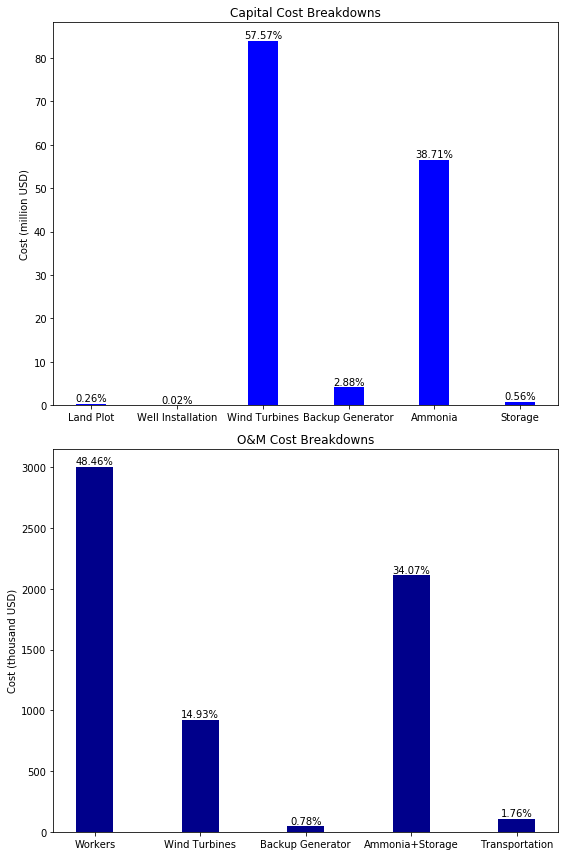

In [215]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8,12))
width = 0.35

x_capital = np.arange(1, 7)
multipliers_capital = np.full(6, 1)
capital, capital_percents = capital_cost_breakdown(params_baseline, multipliers_capital)

x_om = np.arange(1, 6)
multipliers_om = np.full(5, 1)
om, om_percents = om_cost_breakdown(params_baseline, multipliers_om)

labels_capital = ["Land Plot", "Well Installation", "Wind Turbines", "Backup Generator", "Ammonia", "Storage"]
ax1.bar(x_capital, capital/1e6, width, color='blue')
ax1.set_title("Capital Cost Breakdowns")
ax1.set_ylabel('Cost (million USD)')
ax1.set_xticks(x_capital)
ax1.set_xticklabels(labels_capital)
for rect, label in zip(ax1.patches, format_percents(capital_percents)):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2, height*1.002, label, ha='center', va='bottom')
    
labels_om = ["Workers", "Wind Turbines", "Backup Generator", "Ammonia+Storage", "Transportation"]
ax2.bar(x_om, om/1e3, width, color='darkblue')
ax2.set_title("O&M Cost Breakdowns")
ax2.set_ylabel('Cost (thousand USD)')
ax2.set_xticks(x_om)
ax2.set_xticklabels(labels_om)
for rect, label in zip(ax2.patches, format_percents(om_percents)):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width()/2, height*1.002, label, ha='center', va='bottom')

fig.tight_layout()
plt.show()

#### Efficiency-Cost Tradeoffs